# Hydro Routing Example

In [ ]:
import os
import tempfile
from pathlib import Path

import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as sgeo

from ravenpy.utilities import geoserver
from ravenpy.utilities.testdata import get_local_testdata

TESTDIR = os.environ.get("RAVENPY_TESTDATA_PATH", "/home/tjs/git/raven-testdata/")

if not TESTDIR:
    raise FileNotFoundError("RAVENPY_TESTDATA_PATH not set.")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Finding the upstream subbasin for Amadjuak Lake
Located on Baffin Island's Great Plain of the Koukdjuak, Nunavut (https://en.wikipedia.org/wiki/Amadjuak_Lake)

We begin by collecting the feature of the lake using `geoserver.get_hydro_routing_location_wfs()`.

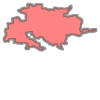

Subbasin ID: 29881.0.


In [ ]:
amadjuak = (-71.225, 65.05)

feature = geoserver.get_hydro_routing_location_wfs(
    coordinates=amadjuak * 2, lakes="1km", level=7
)

with open(tempfile.NamedTemporaryFile(suffix=".gml").name, "wb") as gml:
    gml.write(feature)
    # GeoPandas cannot read a GML from Geoserver directly; Parse with fiona.
    with fiona.open(gml.name) as src:
        feat = next(iter(src))
        geometry = sgeo.shape(feat["geometry"])
        subbasin_id = feat["properties"]["SubId"]

display(geometry)
print(f"Subbasin ID: {subbasin_id}.")

With the subbasin ID (`SubId`) for the feature, we can now find all tributaries using `geoserver.hydro_routing_upstream_ids()`. 

This function asks for a reference GeoDataframe to perform the analysis, and we can collect a subset of this data from our GeoServer instance using `geoserver.get_hydro_routing_attributes_wfs()`. This function returns a URL to a JSON-encoded subset and GeoPandas uses some magic to fetch and load it like a file.

In [ ]:
# With a watershed ID to reduce the size of requests, this will be faster
region_url = geoserver.get_hydro_routing_attributes_wfs(
    attribute="SubId", value="*", lakes="1km", level=7
)
gdf = gpd.read_file(region_url)

gdf_upstream = geoserver.hydro_routing_upstream_ids(subbasin_id, gdf)
display(gdf_upstream)

Number of features: 33


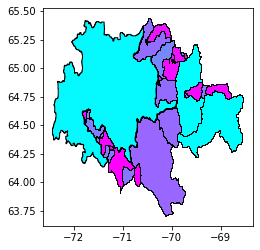

In [ ]:
# Plotting all features upstream of the subbasin of interest, including Amadjuak Lake.

gdf_upstream.plot(column="SubId", cmap="cool", edgecolor="black")
print(f"Number of features: {len(gdf_upstream)}")

We can now aggregate these features to have a continuous area with some specifically-handled aggregated fields, `area` and `MeanElev` 

**WARNING: This is simply for showcasing; `MeanElev` is not a true spatial mean.**

Area : 19779812964.467358 sq.km.
Mean elevation of the region : 245.730393939394 metres.


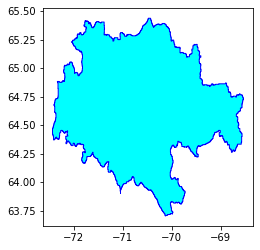

In [ ]:
# We need to write out our GeoDataframe to a file before we can aggregate it.
with tempfile.NamedTemporaryFile(prefix="hydro_routing_", suffix=".json") as tf:
    gdf_upstream.to_file(tf.name, driver="GeoJSON")
    gdf_upstream = gpd.read_file(tf.name)

aggregated = geoserver.hydro_routing_aggregate(gdf_upstream)

aggregated.plot(color="cyan", edgecolor="blue")
print(f"Area : {float(aggregated['area'])} sq.km.")
print(f"Mean elevation of the region : {float(aggregated['MeanElev'])} metres.")